#### SVM

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/SD

/content/gdrive/MyDrive/SD


In [ ]:
!pip install imutils

1/1 [==============================] - 2s 2s/step
Augmenting Anterolisthesis: 1
1/1 [==============================] - 2s 2s/step
Augmenting Anterolisthesis: 2
1/1 [==============================] - 1s 1s/step
Augmenting Anterolisthesis: 3
1/1 [==============================] - 1s 1s/step
Augmenting Anterolisthesis: 4
1/1 [==============================] - 1s 926ms/step
Augmenting Anterolisthesis: 5
1/1 [==============================] - 1s 923ms/step
Augmenting Anterolisthesis: 1
1/1 [==============================] - 1s 971ms/step
Augmenting Anterolisthesis: 2
1/1 [==============================] - 1s 888ms/step
Augmenting Anterolisthesis: 3
1/1 [==============================] - 1s 594ms/step
Augmenting Anterolisthesis: 4
1/1 [==============================] - 1s 594ms/step
Augmenting Anterolisthesis: 5
1/1 [==============================] - 1s 595ms/step
Augmenting Anterolisthesis: 1
1/1 [==============================] - 1s 583ms/step
Augmenting Anterolisthesis: 2
1/1 [===========

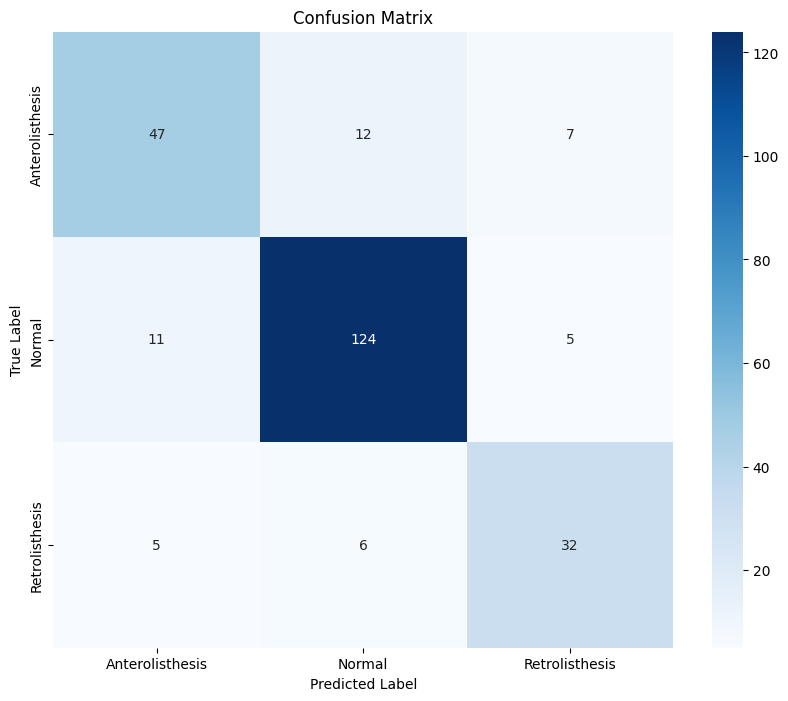

Classification Report:
                 precision    recall  f1-score   support

Anterolisthesis       0.75      0.71      0.73        66
         Normal       0.87      0.89      0.88       140
 Retrolisthesis       0.73      0.74      0.74        43

       accuracy                           0.82       249
      macro avg       0.78      0.78      0.78       249
   weighted avg       0.81      0.82      0.81       249



In [ ]:
import os
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import random

# Load the pre-trained VGG16 model + higher level layers
base_model = VGG16(weights='imagenet', include_top=True)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

# Function to extract features
def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = model.predict(img_data)
    return features.flatten()

# Data augmentation setup
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Paths
image_dir = 'data_LA'  # Change this to your image directory

# Minority classes and their target counts
minority_classes = {'Anterolisthesis': 6, 'Retrolisthesis': 25}
# left_data = []
# left_labels = []
# right_data = []
# right_labels = []
ante_data = []
ante_labels = []
retro_data = []
retro_labels = []
normal_class_data = []
normal_class_labels = []


initial_class_counts = {}
for class_name in os.listdir(image_dir):
    class_dir = os.path.join(image_dir, class_name)
    if os.path.isdir(class_dir):
        class_label = class_name
        initial_class_counts[class_label] = 0
        for img_name in os.listdir(class_dir):
            if img_name.endswith('.jpg'):
                img_path = os.path.join(class_dir, img_name)
                features = extract_features(img_path, model)

                initial_class_counts[class_label] += 1

                if class_label == 'Normal':
                    normal_class_data.append(features)
                    normal_class_labels.append(class_label)

                elif class_label == "Anterolisthesis":
                    ante_data.append(features)
                    ante_labels.append(class_label)

                    # Augmentation
                    img = image.load_img(img_path, target_size=(224, 224))
                    x = image.img_to_array(img)
                    x = np.expand_dims(x, axis=0)
                    x = preprocess_input(x)

                    augmented_count = 0
                    for batch in datagen.flow(x, batch_size=1):
                        if augmented_count >= minority_classes['Anterolisthesis'] - 1:  # Number of samples to be augmented
                            break
                        aug_features = model.predict(batch)
                        ante_data.append(aug_features.flatten())
                        ante_labels.append(class_label)
                        augmented_count += 1
                        print(f"Augmenting Anterolisthesis: {augmented_count}")

                elif class_label == "Retrolisthesis":
                    retro_data.append(features)
                    retro_labels.append(class_label)

                    # Augmentation
                    img = image.load_img(img_path, target_size=(224, 224))
                    x = image.img_to_array(img)
                    x = np.expand_dims(x, axis=0)
                    x = preprocess_input(x)

                    augmented_count = 0
                    for batch in datagen.flow(x, batch_size=1):
                        if augmented_count >= minority_classes['Retrolisthesis'] - 1:  # Number of samples to be augmented
                            break
                        aug_features = model.predict(batch)
                        retro_data.append(aug_features.flatten())
                        retro_labels.append(class_label)
                        augmented_count += 1
                        print(f"Augmenting Retrolisthesis: {augmented_count}")

print(f"Initial class counts (before augmentation): {initial_class_counts}")

# Count after augmentation
augmented_class_counts = {
    'Anterolisthesis': len(ante_labels),
    'Retrolisthesis': len(retro_labels),
    'Normal': len(normal_class_labels)
}
print(f"Class counts after augmentation: {augmented_class_counts}")

# Combine minority data
combined_minority_data = []
combined_minority_labels = []
combined_minority_data = ante_data + retro_data
combined_minority_labels = ante_labels + retro_labels


# Downsample the majority class
selected_indices = random.sample(range(len(normal_class_data)), 700)
selected_normal_data = [normal_class_data[i] for i in selected_indices]
selected_normal_labels = [normal_class_labels[i] for i in selected_indices]

print(f"Class count of Normal class after downsampling: {len(selected_normal_data)}")

# Combine labels before fitting the LabelEncoder
combined_labels = combined_minority_labels + selected_normal_labels

# Convert labels to numerical values
le = LabelEncoder()
le.fit(combined_labels)
combined_minority_labels = le.transform(combined_minority_labels)
selected_normal_labels = le.transform(selected_normal_labels)

# Split the data separately
X_train_min, X_test_min, y_train_min, y_test_min = train_test_split(combined_minority_data, combined_minority_labels, test_size=0.2, random_state=42)
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(selected_normal_data, selected_normal_labels, test_size=0.2, random_state=42)

# Concatenate the splits
X_train = np.concatenate((X_train_min, X_train_norm), axis=0)
X_test = np.concatenate((X_test_min, X_test_norm), axis=0)
y_train = np.concatenate((y_train_min, y_train_norm), axis=0)
y_test = np.concatenate((y_test_min, y_test_norm), axis=0)

# Train XGBoost model
# xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(le.classes_))
# xgb_model.fit(X_train, y_train)

# Train SVM model
# svm_model = SVC(kernel='linear', probability=True)
# svm_model.fit(X_train, y_train)

# Train Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = dt_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred, target_names=le.classes_)
print("Classification Report:")
print(class_report)


Accuracy: 92.77%
Precision: 93.23%
Recall: 92.77%
F1-Score: 92.69%


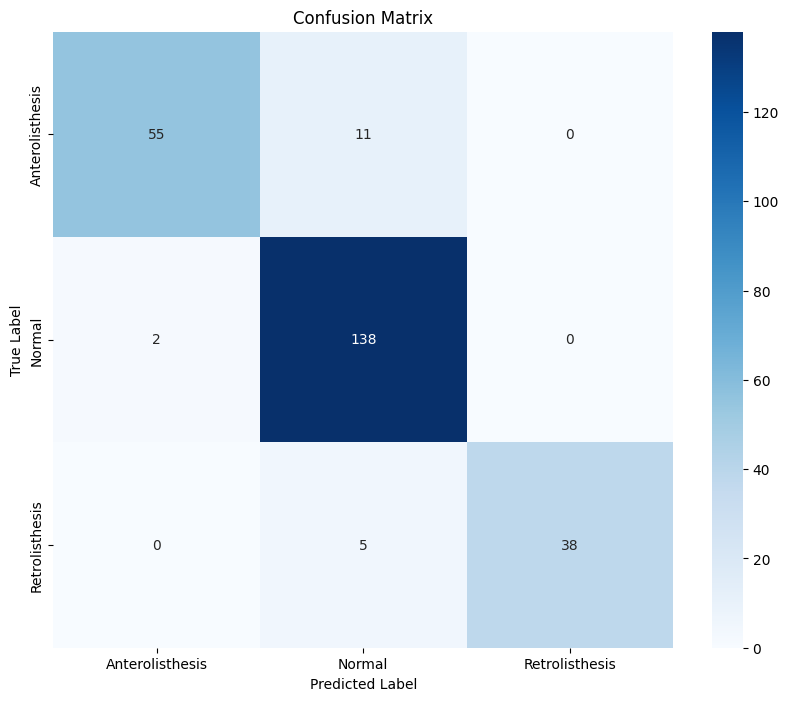

Classification Report:
                 precision    recall  f1-score   support

Anterolisthesis       0.96      0.83      0.89        66
         Normal       0.90      0.99      0.94       140
 Retrolisthesis       1.00      0.88      0.94        43

       accuracy                           0.93       249
      macro avg       0.95      0.90      0.92       249
   weighted avg       0.93      0.93      0.93       249



In [ ]:
# Predict and evaluate
y_pred = xgb_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred, target_names=le.classes_)
print("Classification Report:")
print(class_report)
